# Project 2. Mask Detection

##### Маски играют решающую роль в защите здоровья людей от респираторных заболеваний, поскольку это одна из немногих мер предосторожности, доступных для борьбы с COVID-19 в отсутствие иммунизации. С помощью этого набора данных можно создать модель для выявления людей, носящих маски, не носящих их или носящих маски неправильно.

##### Набор данных содержит 853 изображения, принадлежащих к трем классам, а также их ограничивающие рамки в формате PASCAL VOC.

# Импорт библиотек

In [1]:
# based on https://www.kaggle.com/konstanter/fasterrcnn-pytorch-maskdetection

import numpy as np
import pandas as pd
import os
import shutil
import time
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных в DataLoader

In [2]:
# путь к файлам
images_dir = '/kaggle/input/face-mask-detection/images/'
annotations_dir = '/kaggle/input/face-mask-detection/annotations/'


class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir, width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        
        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0
        
        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # высота и ширина изображения
        wt = img.shape[1]
        ht = img.shape[0]
        
        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt/1.003)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[78]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[113.1163, 146.7200, 163.2312, 205.5200]]), 'labels': tensor([2]), 'area': tensor([2946.7593]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


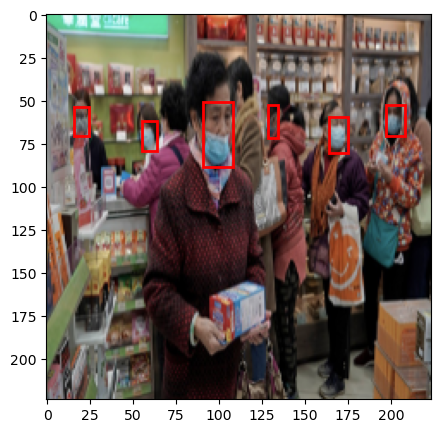

In [3]:
# Вспомогательная функция для визуализации bbox

def plot_img_bbox(img, target):
    fig, ax = plt.subplots(figsize=(5,5), ncols=1)
    ax.imshow(img)
    ax.axis('scaled')
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Отрисуем bbox поверх картинки
        ax.add_patch(rect)
    plt.show()
    
img, target = dataset[35]
plot_img_bbox(img, target)

In [4]:
def get_transform(train):
    
    if train:
        return A.Compose([
#                             A.HorizontalFlip(0.5),
#                             A.RandomBrightnessContrast(p=0.2),
#                             A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
dataset = FaceMaskDataset(images_dir, annotations_dir, 600, 600, transforms= get_transform(train=True))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, 600, 600, transforms= get_transform(train=False))

# разделим данные на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=3,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=3,
    collate_fn=collate_fn)

# Обучение модели

In [10]:
# Возьмём модель FASTERRCNN_RESNET50_FPN_V2, поскольку она лучше подходит для качества при детектировании объектов

def get_model_instance(num_classes):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4
num_epochs = 30
frcnn_df = pd.DataFrame()

model = get_model_instance(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
len_dataloader = len(data_loader)

start_time = time.time()

for epoch in range(num_epochs):
    model.train()  # Training model
    epoch_loss = 0
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()         
        epoch_loss += losses.item()
    print(f'Epoch: {epoch}, total loss: {epoch_loss}')
    
    model.eval()  # Validating model
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=False)
    with torch.no_grad():
        for imgs, annotations in data_loader_test:
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            preds = model(imgs)
            metric.update(preds, annotations)
    metric_res = metric.compute()
    metric_res = {k: v.detach().numpy() for k, v in metric_res.items()}
    metric_res['classes'] = ['all']
    metric_res['epoch'] = [epoch]
    frcnn_df = pd.concat([frcnn_df, pd.DataFrame(metric_res)])

duration = time.time() - start_time
print('Время обучения: {:.0f}m {:.0f}s'.format(duration // 60, duration % 60))

RuntimeError: DataLoader worker (pid(s) 9700) exited unexpectedly

In [ ]:
frcnn_df

In [ ]:
frcnn_df.plot(x='epoch', y='map_50', kind='line', title='FasterRCNNv2 mAP_50')

In [ ]:
# вспомогательная функция принимает исходный прогноз и порог iou

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [ ]:
img, target = dataset_test[4]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), {k: v.to('cpu') for k, v in prediction.items()})

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), {k: v.to('cpu') for k, v in nms_prediction.items()})

# Визуализация итогов

In [ ]:
def plot_image(img_tensor, annotation, predict=True):
    
    fig, ax = plt.subplots(1)
    fig.set_size_inches(12.5, 6.5)
    img = img_tensor.cpu().data
    mask_dic = {1:'without_mask', 2:'with_mask', 3:'mask_weared_incorrect'}
    color_dict = {'without_mask': 'r', 'with_mask': 'g', 'mask_weared_incorrect': 'y'}

    ax.imshow(img.permute(1, 2, 0))
    ax.set_title('Prediction' if predict else 'Target')
    
    annotation = {k: v.detach().to('cpu') for k, v in annotation.items()}
    
    for i,box in enumerate(annotation["boxes"]):
        
        xmin, ymin, xmax, ymax = box
        label = mask_dic[int(annotation['labels'][i].data)]

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color_dict[label],facecolor='none')

        ax.add_patch(rect)
        
        if predict:
            score = int((annotation['scores'][i].data) * 100)
            ax.text(xmin, ymin, f"{score}%", horizontalalignment='center', verticalalignment='center',fontsize=20,color=color_dict[label])
    plt.show()

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
with torch.no_grad():
    preds = model(imgs)

In [ ]:
nms_prediction = apply_nms(preds[4], iou_thresh=0.2)
plot_image(imgs[4], nms_prediction)
plot_image(imgs[4].to('cpu'), annotations[4], False)

In [ ]:
nms_prediction = apply_nms(preds[7], iou_thresh=0.2)
plot_image(imgs[7], nms_prediction)
plot_image(imgs[7].to('cpu'), annotations[7],False)

In [ ]:
nms_prediction = apply_nms(preds[0], iou_thresh=0.2)
plot_image(imgs[0], nms_prediction)
plot_image(imgs[0].to('cpu'), annotations[0],False)

In [ ]:
nms_prediction = apply_nms(preds[2], iou_thresh=0.2)
plot_image(imgs[2], nms_prediction)
plot_image(imgs[2].to('cpu'), annotations[2],False)

## YOLOv8

##### Для данного задания будем использовать модель YOLOv8 как самую совершенную на сегодняшний день

In [ ]:
# СОЗДАДИМ ДАТАСЕТ

# Создадим функцию для чтения файла в формате XML, в дальнейшем преобразуем в формат YOLO

def xml_to_yolo(xml_path):
    bboxes = []
    label_to_id = {'without_mask': 0,'with_mask': 1,'mask_weared_incorrect': 2}
    tree = et.parse(xml_path)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    # Проходим по всем объектам в файле аннотации
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox_tree = obj.find('bndbox')
        x_min = int(bndbox_tree.find('xmin').text)
        y_min = int(bndbox_tree.find('ymin').text)
        x_max = int(bndbox_tree.find('xmax').text)
        y_max = int(bndbox_tree.find('ymax').text)
        
        # Преобразуем координаты в формат YOLO
        x_center = (x_max + x_min) / (2 * w)
        y_center = (y_max + y_min) / (2 * h)
        width = (x_max - x_min) / w
        height = (y_max - y_min) / h
        bboxes.append('{} {:.3f} {:.3f} {:.3f} {:.3f}'.format(label_to_id[label], x_center, y_center, width, height))
    return bboxes

# Функция для создания датасета модели YOLO с преобразованием аннотаций

def create_yolo_dataset(input_path, save_path, images, data_type):

    img_dest_dir = os.path.join(save_path, 'images', data_type)
    lbl_dest_dir = os.path.join(save_path, 'labels', data_type)
    os.makedirs(img_dest_dir)
    os.makedirs(lbl_dest_dir)
    for img in images:
        shutil.copy(os.path.join(input_path, 'images', img), img_dest_dir)
        ann_path = os.path.join(input_path, 'annotations', img.replace('png', 'xml'))
        bboxes = xml_to_yolo(ann_path)
        lbl_path = os.path.join(lbl_dest_dir, img.replace('png', 'txt'))
        with open(lbl_path, 'w') as f:
            f.write('\n'.join(bboxes))

In [ ]:
# СОЗДАДИМ ДАТАСЕТ для модели YOLO

source_dir = '/kaggle/input/face-mask-detection'
images_dir = os.path.join(source_dir, 'images')
dest_dir = 'datasets/facemask'

imgs = [img for img in sorted(os.listdir(images_dir))]

imgs_train, imgs_val = train_test_split(imgs, test_size=0.2, random_state=1)

create_yolo_dataset(source_dir, dest_dir, imgs_train, data_type='train')
create_yolo_dataset(source_dir, dest_dir, imgs_val, data_type='val')

# Создадим конфигурационный файл для датасета
facemask_yaml = f"""
    path: facemask
    train: images/train
    val: images/val
    names:
        0: without_mask
        1: with_mask
        2: mask_weared_incorrect
    """

with open('facemask.yaml', 'w') as f:
    f.write(facemask_yaml)

### Обучение модели

In [ ]:
settings.update({'wandb': False})  # Отключаем логирование

model = YOLO("yolov8s.pt")
start_time = time.time()
model.train(data="facemask.yaml", epochs=num_epochs, batch=16, imgsz=600, cache=True, val=True, exist_ok=True, verbose = False)
duration = time.time() - start_time
print('Время обучения: {:.0f}m {:.0f}s'.format(duration // 60, duration % 60))

## Визуализация результатов

In [ ]:
# Метрики обучения

yolo_df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv', sep=',\s+', engine='python')
yolo_df

In [ ]:
# Батч с размеченными данными

img = Image.open('/kaggle/working/runs/detect/train/val_batch0_labels.jpg')
display(img)

In [ ]:
# Батч с предсказаниями

img = Image.open('/kaggle/working/runs/detect/train/val_batch0_pred.jpg')
display(img)

In [ ]:
# Предсказание обученной моделью

im1 = Image.open('/kaggle/working/datasets/facemask/images/val/maksssksksss163.png')
results = model.predict(source=im1, iou=0.2)
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.title("Prediction")
plt.axis(False)
plt.show()

In [ ]:
# Предсказание обученной моделью

im2 = Image.open('/kaggle/working/datasets/facemask/images/val/maksssksksss462.png')
results = model.predict(source=im2, iou=0.2)
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.title("Prediction")
plt.axis(False)
plt.show()

In [ ]:
# Предсказание обученной моделью

im3 = Image.open('/kaggle/working/datasets/facemask/images/val/maksssksksss245.png')
results = model.predict(source=im3, iou=0.2)
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.title("Prediction")
plt.axis(False)
plt.show()

In [ ]:
# Предсказание обученной моделью

im4 = Image.open('/kaggle/working/datasets/facemask/images/val/maksssksksss204.png')
results = model.predict(source=im4, iou=0.2)
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.title("Prediction")
plt.axis(False)
plt.show()

In [ ]:
# Предсказание обученной моделью

im5 = Image.open('/kaggle/working/datasets/facemask/images/val/maksssksksss352.png')
results = model.predict(source=im5, iou=0.2)
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.title("Prediction")
plt.axis(False)
plt.show()

In [ ]:
# Сравниваем метрику mAP_50 для обеих моделей

yolo_df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv', sep=',\s+', engine='python')

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(frcnn_df['epoch'], frcnn_df['map_50'], label='FasterRCNNv2')
ax.plot(yolo_df['epoch'], yolo_df['metrics/mAP50(B)'], label='YOLOv8')
ax.set_xlabel('Epoch')
ax.set_ylabel('mAP_50')
ax.legend()
ax.set_title('YOLOv8 vs FasterRCNNv2 on validation dataset')
plt.show()

In [ ]:
# Наилучшие значения mAP_50 для каждой из моделей

print('FasterRCNNv2 mAP_50 max: {:.3f}'.format(frcnn_df['map_50'].max()))
print('YOLOv8 mAP_50 max: {:.3f}'.format(yolo_df['metrics/mAP50(B)'].max()))

# Вывод